<a href="https://colab.research.google.com/github/jangjung-coding/lettuce_predict_ai/blob/main/lettuce_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import glob
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate,train_test_split, KFold, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Jupyter note상에 그래프 결과 포함 매직 명령
%matplotlib inline

# Matplotlib 기본 글꼴 정의
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys

# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections

    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

#     # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')

#     # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

# 경고 문제 출력 제한
import warnings

warnings.filterwarnings( 'ignore' )

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
final_data = pd.read_csv('/content/drive/MyDrive/googleCloud AI 인재양성 교육/[프로젝트]상추의 생육 환경 예측 AI/final_dataframe_eng.csv')
final_data.head()

,DATE,modified_temperature,temperature,modified_humidity,humidity,modified_co2,co2,modified_total_light,total_light,predicted_weight_g,case
0,1,0.282266,27.542751,0.325199,78.075041,0.001908,523.986590,0.000014,270032.8895,0.167719,1
1,2,0.373346,26.678482,0.386093,77.590048,0.001854,539.236170,0.000014,269399.5381,0.181787,1
2,3,0.463535,26.157335,0.422638,77.366091,0.001316,760.150330,0.000014,270032.8895,0.265921,1
3,4,0.396371,26.522891,0.319320,78.131650,0.001853,539.535758,0.000014,269511.3567,0.423650,1
4,5,0.373346,26.678482,0.386093,77.590048,0.001854,539.236170,0.000014,269511.3567,0.475272,1


# EDA

# Preprocessing

In [6]:
final_data.columns

Index(['DATE', 'modified_temperature', 'temperature', 'modified_humidity',
       'humidity', 'modified_co2', 'co2', 'modified_total_light',
       'total_light', 'predicted_weight_g', 'case'],
      dtype='object')

In [7]:
delete_cols = ['temperature', 'humidity', 'co2', 'total_light', 'case']
final_data = final_data.drop(delete_cols, axis=1)
final_data.columns

Index(['DATE', 'modified_temperature', 'modified_humidity', 'modified_co2',
       'modified_total_light', 'predicted_weight_g'],
      dtype='object')

In [10]:
X = final_data[['DATE', 'modified_temperature', 'modified_humidity', 'modified_co2', 'modified_total_light']]
y = final_data['predicted_weight_g']

In [12]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# 데이터 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(583, 5)
(146, 5)
(583,)
(146,)


# Modeling
- XGBoost : 결정 트리 기반의 앙상블 학습 모델
- LightGBM : XGBoost와 유사한 앙상블 학습 기법이지만, 더 빠르고 효율적인 학습을 위해 최적화된 모델
- Random Forest Regression : 여러 개의 결정 트리를 사용하여 예측을 수행하는 앙상블 학습 모델
- Simple DNN : 간단한 DNN 모델

참고

https://paperswithcode.com/area/time-series (모델 성능 참고)

https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c (앙상블 모델 설명)

## 1. Random Forest Regression
여러 개의 결정 트리를 사용하여 예측을 수행하는 앙상블 학습 모델

장점:

- 여러 트리의 예측을 평균화하기 때문에 과적합 가능성이 낮다
- 구현이 비교적 간단하며, 기본 설정으로도 좋은 성능을 보임

단점:
- 많은 트리를 생성하므로 메모리 사용량이 많을 수 있음
- 많은 트리를 거쳐 예측하기 때문에 실시간 예측에는 부적합할 수 있음

In [13]:
# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [14]:
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {rf_test_rmse:.3f}")

Train RMSE: 5.228
Test RMSE: 14.544


## 2. XGBoost (Extreme Gradient Boosting)
XGBoost는 결정 트리 기반의 강력한 앙상블 학습 기법

장점:
- 빠른 연산 속도와 높은 예측 성능을 제공
- 과적합 방지를 위한 다양한 규제 기법을 포함

단점:
- 큰 데이터셋에서는 메모리 사용량이 많다
- 하이퍼파라미터 튜닝이 복잡할 수 있다

In [15]:
# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# 모델 평가 (RMSE)
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {xgb_test_rmse:.3f}")

Train RMSE: 0.149
Test RMSE: 13.124


## 3. LightGBM (Light Gradient Boosting Machine)
LightGBM은 대용량 데이터셋에서 빠르고 효율적인 학습을 위한 앙상블 기법

장점:
- 학습 속도가 매우 빠름
- 메모리 효율성이 높음

단점:

- 작은 데이터셋에서는 성능이 저하될 수 있음
- 데이터 전처리와 형식에 민감할 수 있음

In [17]:
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1
}

lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data])

In [18]:
y_train_pred = lgb_model.predict(X_train_scaled, num_iteration=lgb_model.best_iteration)
y_test_pred = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {lgb_test_rmse:.3f}")

Train RMSE: 5.527
Test RMSE: 12.867


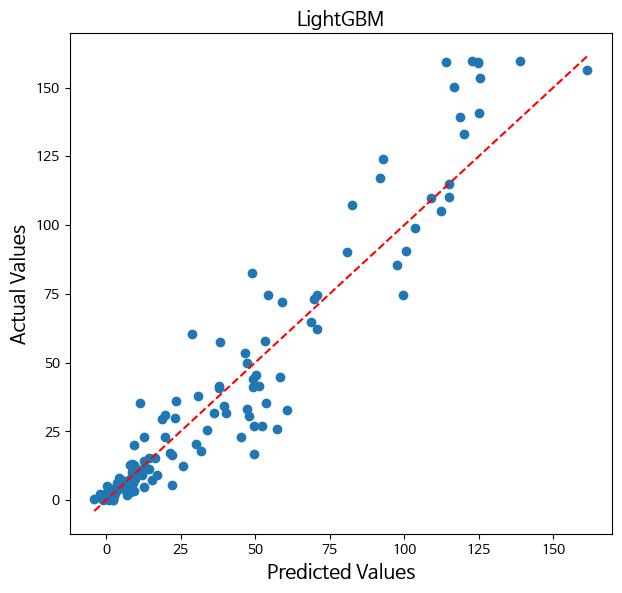

In [19]:
plt.figure(figsize=(7, 6.5))
plt.scatter(y_test_pred,y_test)

min_val = min(np.min(y_test), np.min(y_test_pred))
max_val = max(np.max(y_test), np.max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('LightGBM')
plt.show()

In [20]:
def predict_weight(model_name, modified_DATE, modified_temperature, modified_humidity, modified_co2, modified_total_light):
    if model_name == 'Random Forest':
        model = rf_model
    elif model_name == 'XGBoost':
        model = xgb_model
    elif model_name == 'LightGBM':
        model = lgb_model
    else:
        raise ValueError("Invalid model name. Choose 'Random Forest', 'XGBoost', or 'LightGBM'.")

    input_features = np.array([[modified_DATE, modified_temperature, modified_humidity, modified_co2, modified_total_light]])

    predicted_weight = model.predict(input_features)

    return predicted_weight[0]

In [22]:
# 사용자 입력 받기
model_name = input("Enter model (Random Forest, XGBoost, LightGBM): ")
modified_DATE = float(input("Enter date: "))
modified_temperature = float(input("Enter temperature: "))
modified_humidity = float(input("Enter humidity: "))
modified_co2 = float(input("Enter CO2: "))
modified_total_light = float(input("Enter total light: "))

predicted_weight = predict_weight(model_name, modified_DATE, modified_temperature, modified_humidity, modified_co2, modified_total_light)
print(f"Predicted Weight: {predicted_weight:.2f} g")

Enter model (Random Forest, XGBoost, LightGBM): LightGBM
Enter date: 24
Enter temperature: 28
Enter humidity: 80
Enter CO2: 600
Enter total light: 200000
Predicted Weight: 156.42 g


## 4. 단순 딥러닝 모델

In [23]:
X = X.to_numpy()
y = y.to_numpy()

In [24]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [25]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [26]:
def create_deep_learning_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = X_train_scaled.shape[1]
model = create_deep_learning_model(input_shape)
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_scaled = model.predict(X_test_scaled).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Epoch 1/50
15/15 [==============================] - 1s 18ms/step - loss: 0.0654 - val_loss: 0.0647
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0390 - val_loss: 0.0462
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0321 - val_loss: 0.0420
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0286 - val_loss: 0.0398
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0378
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0365
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0358
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0351
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0334
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0329
Epoch 11/50
15/15 

# BenchMark

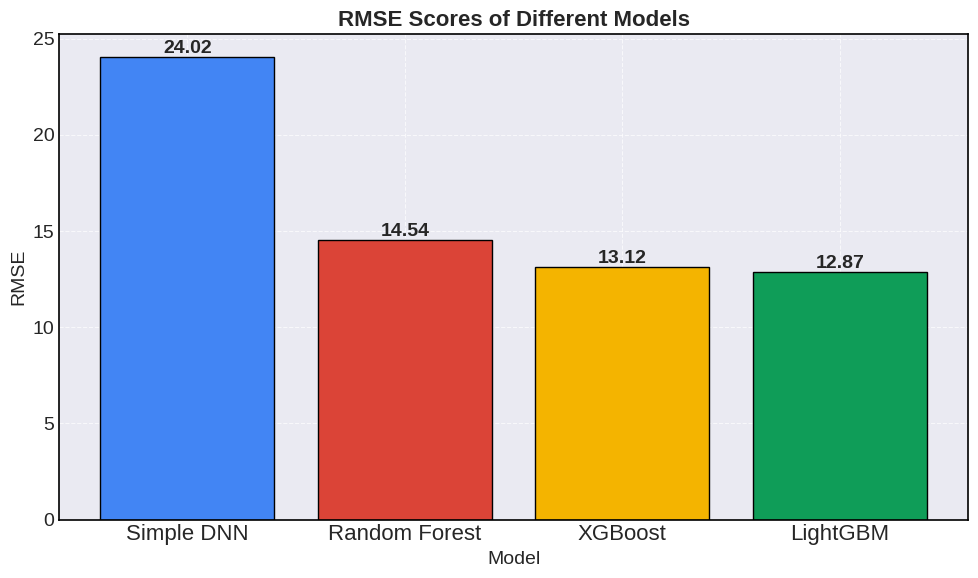

In [27]:
rmse_list = rmse, rf_test_rmse, xgb_test_rmse, lgb_test_rmse

model_names = ['Simple DNN', 'Random Forest', 'XGBoost', 'LightGBM']

plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(model_names, rmse_list, color=['#4285F4', '#DB4437', '#F4B400', '#0F9D58'], edgecolor='black', linewidth=1)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('RMSE Scores of Different Models', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=14)

ax.grid(True, linestyle='--', alpha=0.7)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

# Model Visualization

In [ ]:
rf_model = rf_model

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=train_X.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

In [ ]:
model = xgb_model

def plot_tree_structure(model, num_trees, save_as_pdf=False):

    # 트리 구조 시각화
    plt.figure(figsize=(20, 20))
    xgb.plot_tree(model, num_trees=num_trees, rankdir='LR')  # 트리의 방향을 왼쪽에서 오른쪽으로 설정
    plt.title(f'Tree {num_trees} Visualization')
    plt.show()

tree_index = 0
plot_tree_structure(model, num_trees=tree_index, save_as_pdf=False)

In [ ]:
# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', title='Feature Importance', xlabel='Feature Weight', ylabel='Features')
plt.show()